# _Skin Cancer Image Classification: Nov. 26, 2019_

This notebook builds on the work done in `trial3-skin-cancer.ipynb`. The modification that I'm going to make in this particular notebook is to implement the [`Ranger`](https://medium.com/@lessw/new-deep-learning-optimizer-ranger-synergistic-combination-of-radam-lookahead-for-the-best-of-2dc83f79a48d) optimizer. 

The process will be similar though, namely:
- We'll use the weights from the training done a smaller subset of the data, which also had a smaller image size.
- We'll then utilize the entire training set and train for 10 epochs

In [18]:
# mount your Google Drive, giving us access to any files we have stored there
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [0]:
# import deep learning libraries
import torch
import fastai
from fastai import *
from fastai.vision import *

In [19]:
# import os library to better help us navigate directories (which in this) case is our Google Drive
import os

# what is our current working directory?
print("Our current working directory is '{}'.".format(os.getcwd()))

Our current working directory is '/content/gdrive/My Drive/projects/skin-cancer'.


In [20]:
# change our directory to the one associated with this project
os.chdir('/content/gdrive/My Drive/projects/skin-cancer')

# lets confirm that it updated the directory accordingly
os.getcwd()

'/content/gdrive/My Drive/projects/skin-cancer'

# _Create DataFrame_

In [21]:
from pathlib import Path

#create path variable to primary directory
path = Path(os.getcwd())
path

PosixPath('/content/gdrive/My Drive/projects/skin-cancer')

In [22]:
import pandas as pd

df = pd.read_csv(path/'skin-data/HAM10000_metadata.csv')
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [0]:
diagnosis_dict = {
    'akiec': 'Actinic keratoses', # potential pre-cancer
    'bcc': 'Basal cell carcinoma', # not so good
    'bkl': 'Benign keratosis', # benign is good
    'df': 'Dermatofibroma', # benign
    'mel': 'Melanoma', # very bad
    'nv': 'Melanocytic nevi', # common mole
    'vasc': 'Vascular lesions' # could be benign or malignant
    }

In [0]:
# create a new column with a more specific diagnosis (better able to understand diagnosis)
df['diagnosis'] = df['dx'].map(diagnosis_dict).astype('category')

In [25]:
df['diagnosis'].value_counts(normalize=True)

Melanocytic nevi        0.669496
Melanoma                0.111133
Benign keratosis        0.109735
Basal cell carcinoma    0.051323
Actinic keratoses       0.032651
Vascular lesions        0.014179
Dermatofibroma          0.011483
Name: diagnosis, dtype: float64

# _Data Augmentation_

In [0]:
tfms = get_transforms(do_flip=True, 
                      flip_vert=True,
                      max_rotate=25,
                      max_zoom=1.0,
                      xtra_tfms=dihedral())

# _Create `data` object with all available images_

In [0]:
data = ImageDataBunch.from_df(
    path=path/'skin-data/HAM10000_images_part_1',
    df=df, # take from full dataframe with only relevant information
    valid_pct=0.2, 
    seed=1, 
    fn_col='image_id',
    label_col='diagnosis', 
    suffix='.jpg', 
    ds_tfms=tfms, 
    size=224,
    bs=32
)

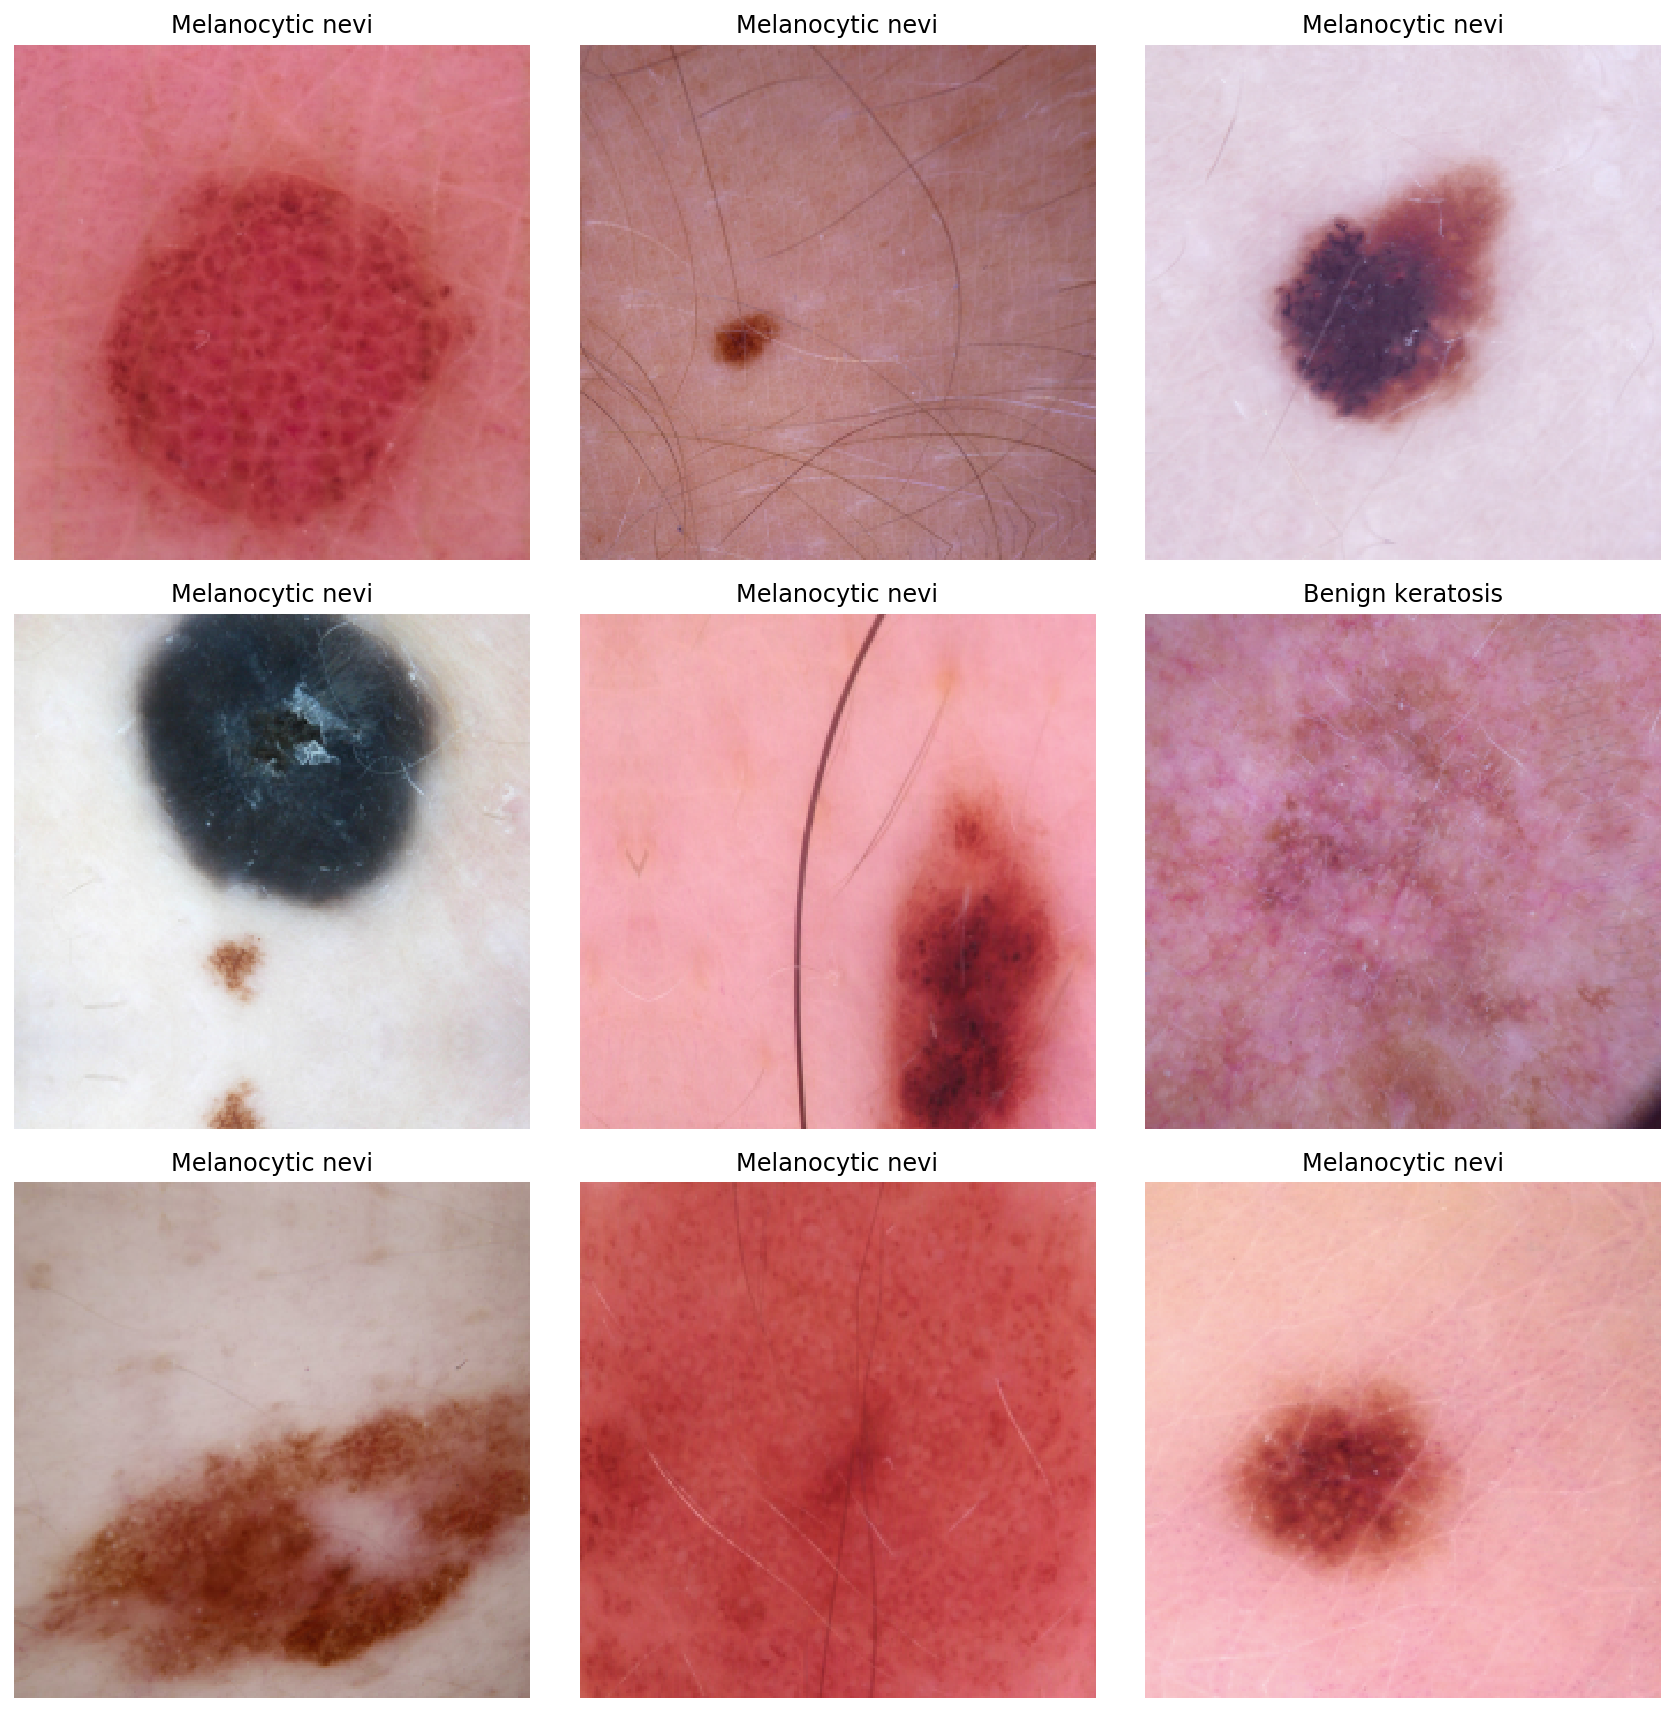

In [31]:
data.show_batch(rows=3)

In [32]:
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (8012 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Benign keratosis,Benign keratosis,Benign keratosis,Benign keratosis,Benign keratosis
Path: /content/gdrive/My Drive/projects/skin-cancer/skin-data/HAM10000_images_part_1;

Valid: LabelList (2003 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Melanocytic nevi,Melanocytic nevi,Melanocytic nevi,Melanocytic nevi,Basal cell carcinoma
Path: /content/gdrive/My Drive/projects/skin-cancer/skin-data/HAM10000_images_part_1;

Test: None

# _Implement Ranger_

In [0]:
from joetools import ranger

In [61]:
optar = partial(ranger.Ranger)
optar

functools.partial(<class 'joetools.ranger.Ranger'>)

# _Create Learner Object_

In [0]:
import fastai


learn = cnn_learner(data, 
                    models.resnet50, 
                    metrics=[accuracy, Recall(), Precision()], 
                    opt_func=optar,
                    bn_wd=False,
                    true_wd=True,
                    path=path)

In [73]:
# load weights from training on sample
learn.load('starting_sample');

set state called


In [0]:
# workaround for using Ranger (see link below)
learn.unfreeze()

**Link to Post on frozen/unfrozen models with Ranger**: [fast.ai link](https://forums.fast.ai/t/meet-ranger-radam-lookahead-optimizer/52886/46)

# _Training Run 1_

set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-06
Min loss divided by 10: 3.31E-03


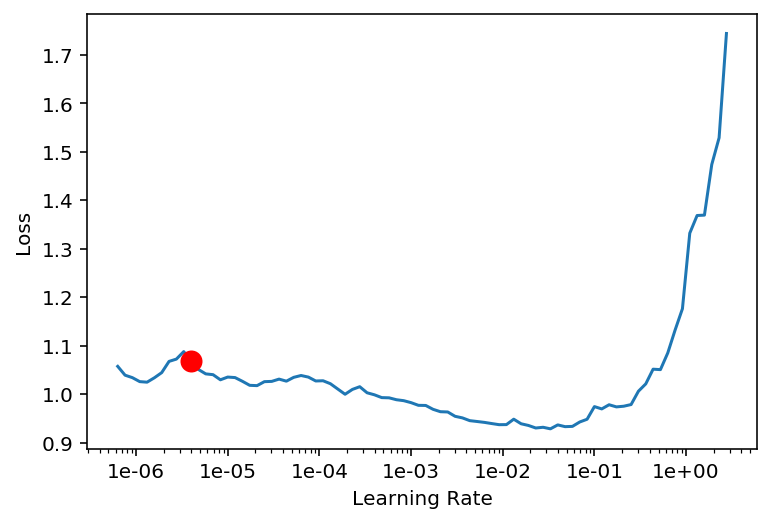

In [75]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [76]:
from fastai.callbacks import SaveModelCallback

learn.fit_one_cycle(10, callbacks=[(SaveModelCallback(learn, every='improvement', 
                                                      monitor='accuracy', name='nov26'))])

epoch,train_loss,valid_loss,accuracy,recall,precision,time
0,0.827906,0.644690,0.761857,0.474872,0.680308,14:16
1,0.672289,0.572731,0.789815,0.572599,0.704595,07:25
2,0.595738,0.506119,0.821767,0.617850,0.768791,07:13
3,0.539448,0.517360,0.809286,0.582212,0.748081,07:16
4,0.506803,0.491218,0.818772,0.643024,0.774875,07:22
5,0.426141,0.414563,0.845731,0.668914,0.800840,07:20
6,0.431330,0.393766,0.847229,0.656553,0.793252,07:23
7,0.322652,0.349533,0.877683,0.744425,0.842475,07:19
8,0.307640,0.335524,0.882676,0.770517,0.844392,07:19
9,0.275556,0.332473,0.879181,0.756818,0.824672,07:21


/usr/local/lib/python3.6/dist-packages/fastai/metrics.py:191: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")


Better model found at epoch 0 with accuracy value: 0.7618572115898132.
Better model found at epoch 1 with accuracy value: 0.7898153066635132.
Better model found at epoch 2 with accuracy value: 0.8217673301696777.
Better model found at epoch 5 with accuracy value: 0.8457313776016235.
Better model found at epoch 6 with accuracy value: 0.8472291827201843.
Better model found at epoch 7 with accuracy value: 0.8776834607124329.
Better model found at epoch 8 with accuracy value: 0.8826760053634644.
set state called


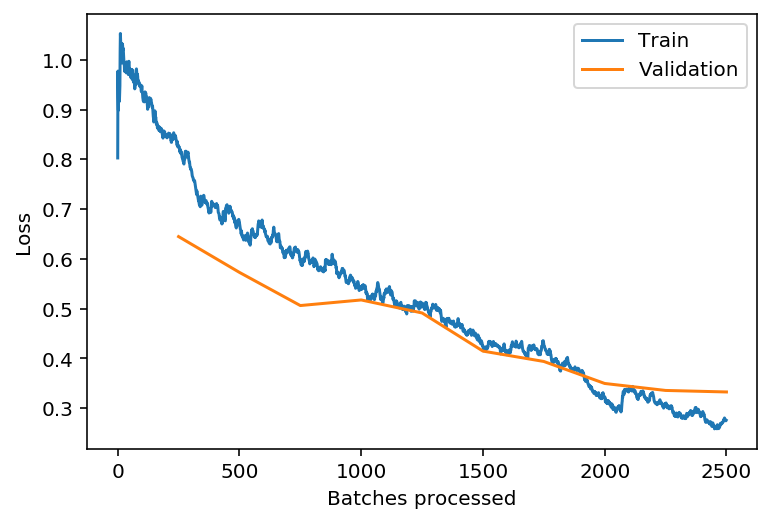

In [77]:
learn.recorder.plot_losses()

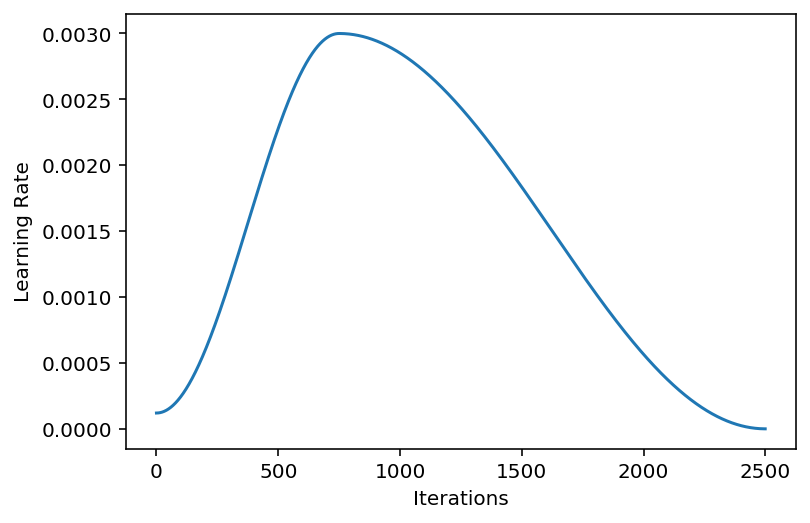

In [78]:
learn.recorder.plot_lr()

# _Interpretation_

In [79]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

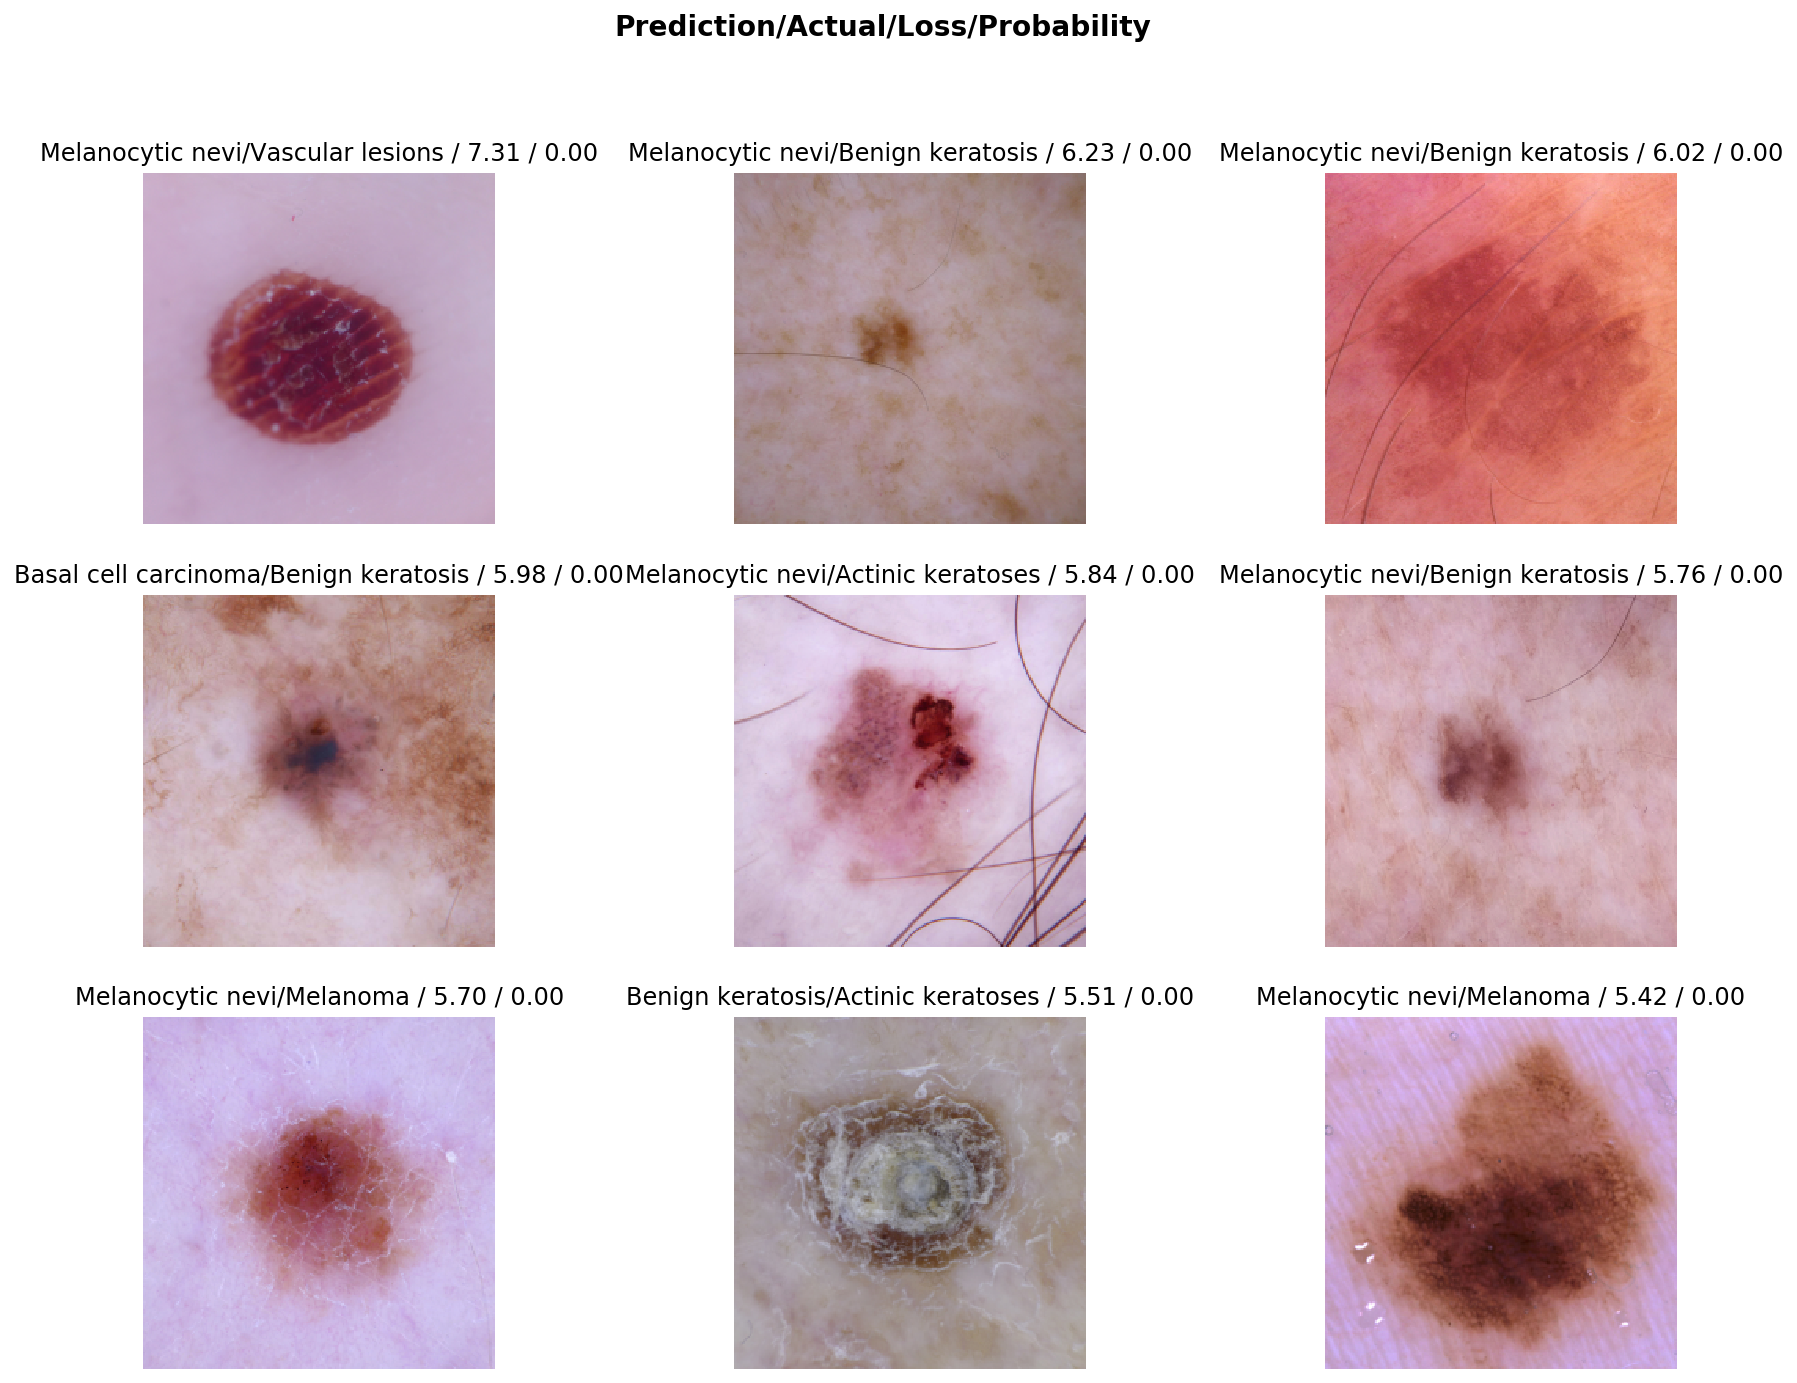

In [81]:
interp.plot_top_losses(9, figsize=(15,11))

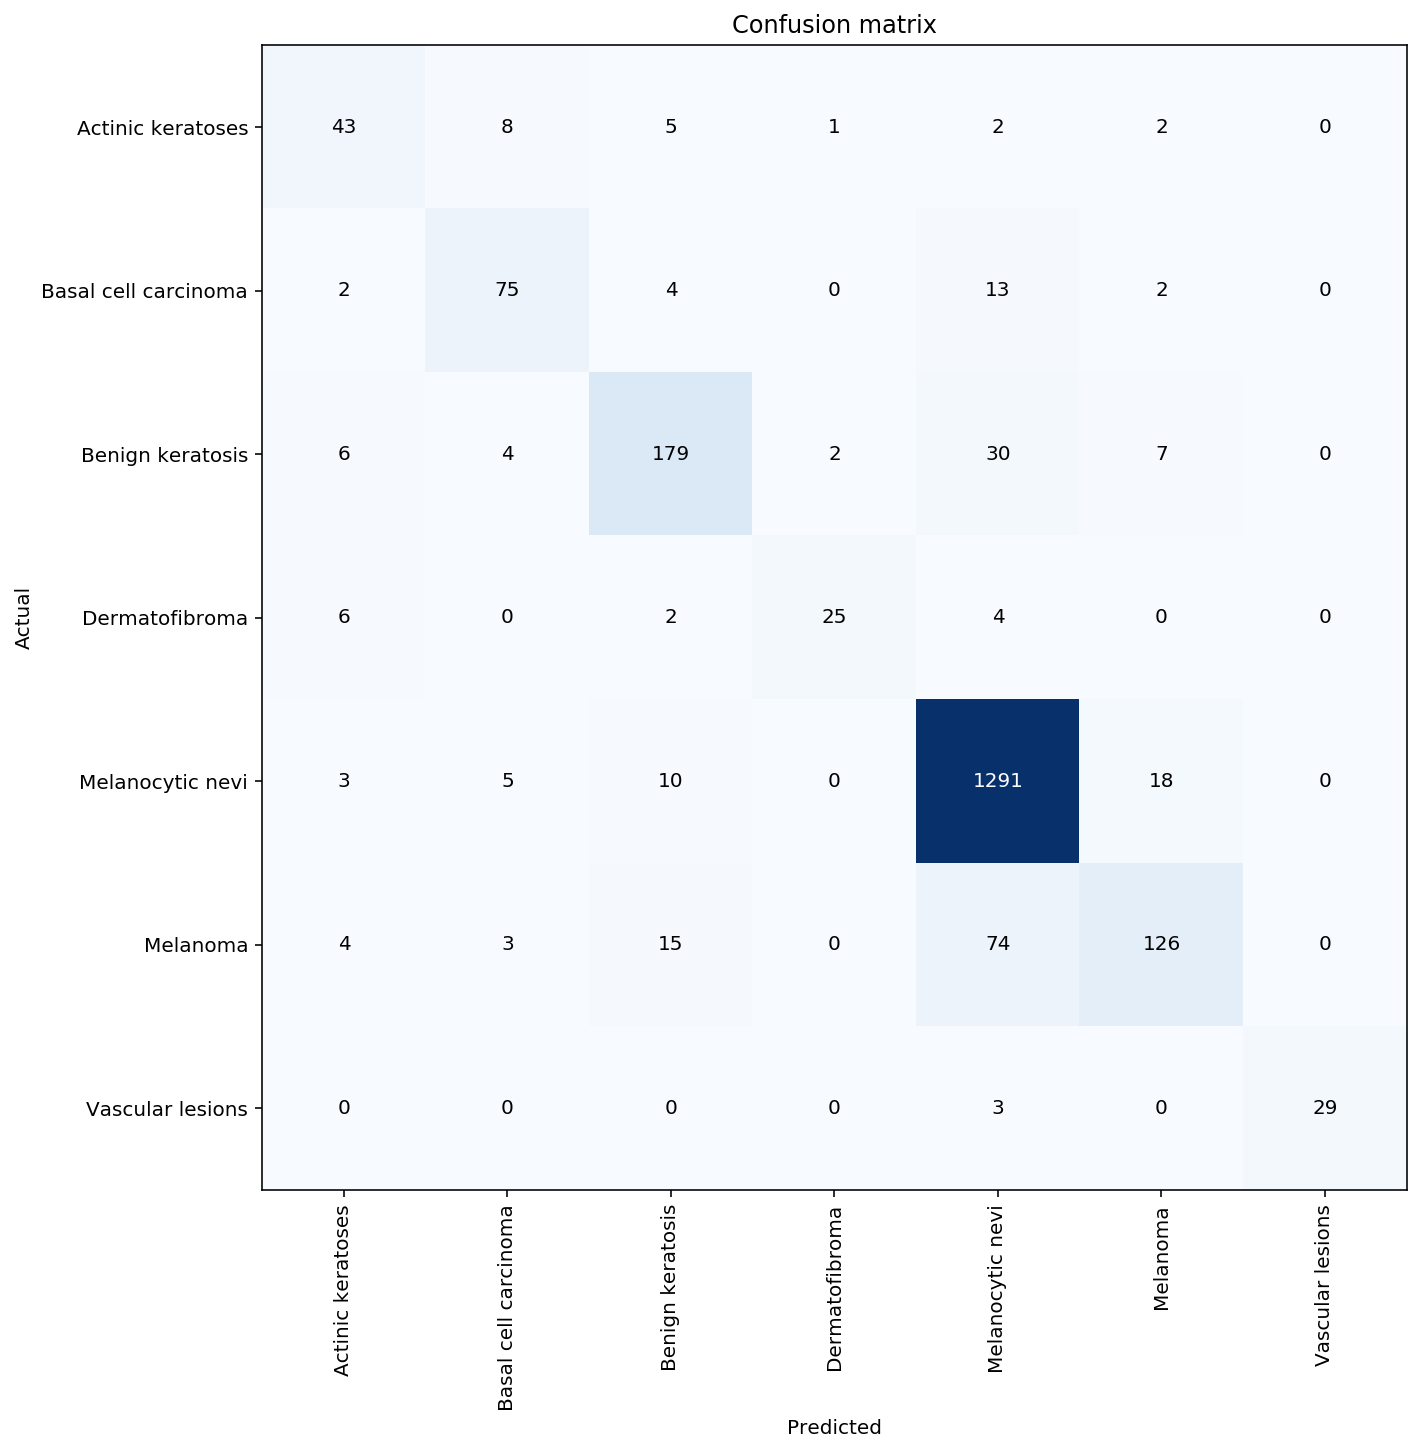

In [82]:
interp.plot_confusion_matrix(figsize=(10,10))